In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random

In [57]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score

In [58]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use('dark_background')
cmm = sns.color_palette("light:b", as_cmap=True)
cmf = sns.color_palette("light:orange", as_cmap=True)

In [59]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='magma', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    #fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

In [60]:
## for males

In [61]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_all.parquet')
mdf_all = pd.read_parquet(path)
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_most_used.parquet')
mdf = pd.read_parquet(path)

In [62]:
## filter out bad days - 
bad_session=[221, 228]
#bad_syllable=[44,89]
bad_syllable=[44]
bad_mouse='04_01'
new_df=mdf.copy()
new_df.drop(bad_session, level=0, axis=0, inplace=True)
new_df.drop(bad_mouse, level=1, axis=0, inplace=True)
new_df.drop(bad_syllable, axis=1, inplace=True)

In [63]:
df_indv=mdf.groupby(['mouse','age']).mean()

In [64]:
#days =df_indv['age'].to_numpy()
#df_indv['wks'] = np.floor(days/7).astype(int)
#df_indv['months'] = np.ceil(days/30).astype(int)
#df_indv.set_index(['wks','months'])

In [65]:
df=df_indv.copy().reset_index()

In [66]:
'''
#on pcs
pca = PCA(n_components=10)
pcs=pca.fit_transform(np.log(df_indv + 1e-6))
pc_df = pd.DataFrame(pcs)
pc_df['age'] = df['age']
pc_df['mouse'] = df['mouse']
df=pc_df.copy()
'''

"\n#on pcs\npca = PCA(n_components=10)\npcs=pca.fit_transform(np.log(df_indv + 1e-6))\npc_df = pd.DataFrame(pcs)\npc_df['age'] = df['age']\npc_df['mouse'] = df['mouse']\ndf=pc_df.copy()\n"

In [67]:
## decoder

In [68]:
# choose a model
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 250)
#clf = LinearRegression()

# choose cross validation scheme
#cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
cv=5

#number of iterations for shuffle
it=100

In [69]:
xmale = pd.DataFrame()
a=0
n=5 # number of consecutive days for calculate over
age=[]
acc=[]
b=False
sh_acc=[]
sh_ages=[]
#while not b:
while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale,xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].nunique()
    keep_mice = list(rep_counts[rep_counts >= n].index) # keep mice that have at least 5 sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if xmale.empty:
        break
    # run identity decoder for this matrix
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    ymale=xmale['mouse']
    x = xmale.drop(['mouse','age'], axis=1).to_numpy()
    x = np.log(x + 1e-6) # convert to linear ###uncomment when NOT using pcs!!!
    y_pred = cross_val_predict(clf, x, ymale, cv=cv)
    temp_acc=np.mean(np.mean(cross_val_score(clf, x, ymale, cv=cv)))
    acc.append(temp_acc)  
    
    #shuffle
    for i in tqdm(range(it)):
        ysh_temp=np.random.permutation(ymale)
        y_pred_temp = cross_val_score(clf, x, ysh_temp, cv=cv)
        sh_acc.append(np.mean(y_pred_temp))
        sh_ages.append(np.floor(np.mean(xmale['age'])).astype(int))

    # handle variables for the loop
    xmale = pd.DataFrame()
    #temp_acc=[]
    a=a+1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 92.63it/s]


In [70]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age


In [71]:
df

,acc,ages
0,0.450000,24
1,0.537500,26
2,0.637500,27
3,0.687500,29
4,0.625000,31
5,0.650000,34
6,0.675000,38
7,0.637500,43
8,0.687500,47
9,0.675000,52


In [72]:
df = df[~df.ages.isin([469,473,477])]
df_sh = df_sh[~df_sh.ages.isin([469,473,477])]

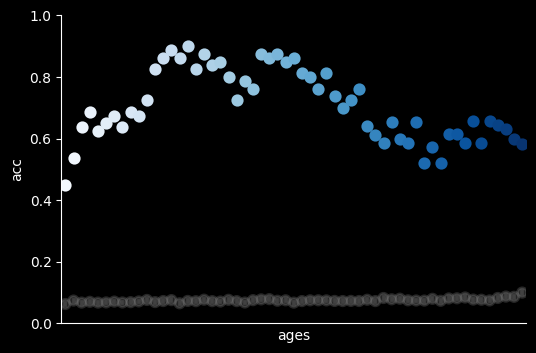

In [73]:
fig, ax = plt.subplots(figsize=(6, 4))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
#sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se',join=False)
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              dodge=0, 
              join=False, 
              ax=ax, 
              scale=1,
              hue='ages',
              palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
             )
plt.legend([],[], frameon=False)
plt.xticks([])
ax.set_ylim([0,1])
sns.despine()
#ax.set_title('identity decoding in different ages bin=' + str(n))
plt.savefig(data_loc +'long_identity_decoder.pdf', bbox_inches='tight')

In [74]:
# identity decoder from different datapoint to final datapoint

In [75]:
#create test data - average of the 5 final data point of each mouse
n2=4
xtest=pd.DataFrame()
df=df_indv.copy().reset_index()
for m,_df in enumerate(df.groupby('mouse')):
        xtest_temp = _df[1][-n2:]
        xtest = pd.concat([xtest,xtest_temp])

In [76]:
xtest = xtest.groupby('mouse').mean()
xt=xtest.drop(['age'], axis=1).to_numpy()
#xt=xtest.to_numpy()
xt = np.log(xt + 1e-6)
yt = xtest.index.get_level_values(0).to_numpy()

In [77]:
out = defaultdict(list)
xmale = pd.DataFrame()
out = defaultdict(list)
acc=[]
a=0
age=[]
acc=[]
b=False
sh_acc=[]
sh_ages=[]
#while not b:
while True:
    # build the current age matrix
    for m,_df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale,xmale_temp])
    rep_counts = xmale.groupby('mouse')['age'].nunique()
    keep_mice = list(rep_counts[rep_counts >= n].index) # keep mice that have at least 5 sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if xmale.empty:
        break
        
    # run identity decoder for this matrix
    age.append(np.floor(np.mean(xmale['age'])).astype(int))
    ymale=xmale['mouse']
    x = xmale.drop(['mouse','age'], axis=1).to_numpy()
    x = np.log(x + 1e-6) # convert to linear
    clf.fit(x, ymale)
    y_predict = clf.predict(xt)
    out['y_true'].append(yt)
    out['y_pred'].append(y_predict)
    out['acc'].append(accuracy_score(yt,y_predict))
    acc.append(accuracy_score(yt,y_predict))  

    #shuffle
    for i in tqdm(range(it)):
        ysh_temp=np.random.permutation(ymale)
        clf.fit(x, ysh_temp)
        shy_predict = clf.predict(xt)
        out['shy_pred'].append(shy_predict)
        out['sh_acc'].append(accuracy_score(yt,shy_predict))
        sh_acc.append(accuracy_score(yt,shy_predict))  
        sh_ages.append(np.floor(np.mean(xmale['age'])).astype(int))

    # handle variables for the loop
    xmale = pd.DataFrame()
    a=a+1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 424.78it/s]


In [78]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age

In [79]:
df

,acc,ages
0,0.0625,24
1,0.0625,26
2,0.0625,27
3,0.0625,29
4,0.0625,31
5,0.0625,34
6,0.1250,38
7,0.1250,43
8,0.1875,47
9,0.1250,52


In [80]:
df = df[~df.ages.isin([473,477])]
df_sh = df_sh[~df_sh.ages.isin([473,477])]

In [86]:
df

,acc,ages
0,0.0625,24
1,0.0625,26
2,0.0625,27
3,0.0625,29
4,0.0625,31
5,0.0625,34
6,0.1250,38
7,0.1250,43
8,0.1875,47
9,0.1250,52


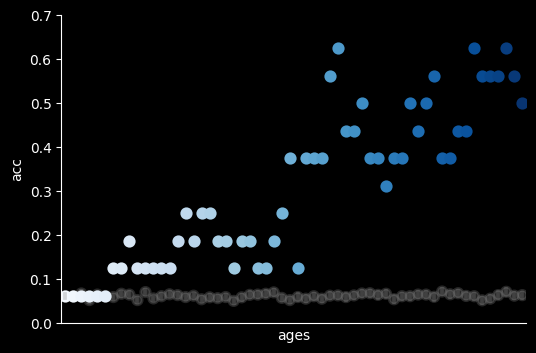

In [85]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se',join=False)
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar='se')
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
#fig, ax = plt.subplots(figsize=(6, 6))
sns.pointplot(data=df, x="ages", y="acc",dodge=0, join=False, ax=ax, 
              #scale=1,
              hue='ages',
              palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
             )
#sns.boxplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
#sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='blue',estimator='mean', errorbar='se')
plt.legend([],[], frameon=False)
plt.xticks([])
ax.set_ylim([0,0.7])
sns.despine()
plt.savefig(data_loc +'long_identity_decoder_final_point.pdf', bbox_inches='tight')